In [254]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import procyclingstats as pcs
import os

# Individual riders results
Get all results of a rider from a season. Use the procyclingstats library

In [303]:
def remove_(riders):
    """Some female names are also scraped, probably more, also remove duplicates"""
    to_remove = ['annemiek-van-vleuten', 'elisa-longo-borghini', 'katarzyna-niewiadoma', 'remco-evenepoel']
    new_riders = []
    indices = []
    for i, rider in enumerate(riders):
        if rider not in to_remove and rider not in new_riders:
            new_riders.append(rider)
            indices.append(i)
            
    return new_riders, indices

def get_riders_tdf(season):
    riders = []
    try:
        url_startlist = f"https://www.procyclingstats.com/race/tour-de-france/{season}/startlist"
        page = requests.get(url_startlist)
        soup = BeautifulSoup(page.content, "html.parser")
        #FIXME There is a bug here, more stuff is being taken
        for a in soup.find_all("a", href=True):
            href = a['href']
            if href.startswith('rider/'):
                rider = href[6:]
                riders.append(rider)
    except:
        files = os.listdir('rider_data')
        for file in files:
            if str(season) in file:
                riders.append(file.split('_')[0])
                
    riders, _ = remove_(riders)
    return riders

get_riders_tdf(2021)[:5]

['anthony-turgis',
 'soren-kragh-andersen',
 'andreas-kron',
 'davide-ballerini',
 'ruben-fernandez']

In [256]:
def get_rider_results(rider, season):
    url = f"rider.php?xseason={season}&zxseason=&pxseason=equal&sort=date&race=&km1=&zkm1=&pkm1=equal&limit=200&topx=&ztopx=&ptopx=smallerorequal&type=&znation=&continent=&pnts=&zpnts=&ppnts=equal&level=&rnk=&zrnk=&prnk=equal&exclude_tt=0&racedate=&zracedate=&pracedate=equal&name=&pname=contains&category=&profile_score=&zprofile_score=&pprofile_score=largerorequal&filter=Filter&id={rider}&p=results&s=all"
#     return pcs.RiderResults(url).results('rank', 'stage_name', 'pcs_points')
    filename = f'rider_data/{rider}_{season}.csv.gz'
    if os.path.exists(filename):
        df = pd.read_csv(filename, index_col=0)
    else:
        df = pd.DataFrame(pcs.RiderResults(url).results())#'rank', 'stage_name', 'distance'))
        df['stage_name'] = f"{season} " + df['stage_name']
        df.to_csv(filename)
    return df

In [258]:
wilco = get_rider_results('wilco-kelderman', 2021)
wilco.sort_values('pcs_points', ascending=False).head(5)

,date,rank,stage_url,stage_name,nationality,class,distance,pcs_points,uci_points
8,2021-07-18,5.0,race/tour-de-france/2021/gc,2021 Tour de France,FR,2.UWT,NaN,280,475.0
31,2021-06-06,4.0,race/dauphine/2021/gc,2021 Critérium du Dauphiné,FR,2.UWT,NaN,140,275.0
54,2021-03-28,5.0,race/volta-a-catalunya/2021/gc,2021 Volta Ciclista a Catalunya,ES,2.UWT,NaN,120,180.0
41,2021-05-02,10.0,race/tour-de-romandie/2021/gc,2021 Tour de Romandie,CH,2.UWT,NaN,70,85.0
28,2021-06-27,4.0,race/tour-de-france/2021/stage-2,2021 Tour de France | Stage 2,FR,2.UWT,183.5,40,15.0


In [390]:
#Can also get all info in a column, but that is a lot of info
def get_rider_all_results(rider, season):
    res_0 = get_rider_results(rider, season)
    res_1 = get_rider_results(rider, season-1)
    res_2 = get_rider_results(rider, season-2)
    res = pd.concat([res_0, res_1, res_2])[['stage_url', 'rank']]
    res.drop_duplicates(inplace=True)
    res = res.transpose()
    res.columns = res.iloc[0]
    res['name'] = rider
    res['season'] = season
    return res.drop(labels='stage_url')

In [391]:
season = 2023
riders = get_riders_tdf(season)
results = []
for rider in riders:
    results.append(get_rider_all_results(rider, season))
df = pd.concat(results)

In [187]:
def get_mean_pcs_points_rank(df):
    #do not use TDF results
#     df_ = df[~df['stage_name'].str.contains('Tour de France')]
    return np.mean(df['pcs_points'])/np.mean(df['rank'])

def get_rider_stats(rider, season):
    """
    Get the average pcs score of the last 3 years and return the tdf result of this year
    Is there a correlation between those?
    """
    #Get results of last 3 seasons
    results_0 = get_rider_results(rider, season)
    results_1 = get_rider_results(rider, season-1)
    results_2 = get_rider_results(rider, season-2)

    #Score of this year, but without the TDF, this is what I want to predict
    score_0 = get_mean_pcs_points_rank(results_0[~results_0['stage_name'].str.contains('Tour de France')])
    score_1 = get_mean_pcs_points_rank(results_1)
    score_2 = get_mean_pcs_points_rank(results_2)
    
    # get TDF results, this is what needs to be predicted
    tdf_0 = results_0[results_0['stage_name'].str.contains('Tour de France')]
    if not tdf_0.empty:
        try:
            rank_gc = tdf_0[tdf_0['stage_name'] == f'{season} Tour de France']['rank'].iloc[0]
        except (KeyError, IndexError):
            rank_gc = np.nan
        try:
            rank_points = tdf_0[tdf_0['stage_name'] == f'{season} Tour de France | Points classification']['rank'].iloc[0]
        except (KeyError, IndexError):
            rank_points = np.nan
        try:
            rank_mount = tdf_0[tdf_0['stage_name'] == f'{season} Tour de France | Mountains classification']['rank'].iloc[0]
        except (KeyError, IndexError):
            rank_mount = np.nan
        try:
            rank_youth = tdf_0[tdf_0['stage_name'] == f'{season} Tour de France | Youth classification']['rank'].iloc[0]
        except (KeyError, IndexError):
            rank_youth = np.nan

        stages = tdf_0[tdf_0['stage_name'].str.contains('Stage')]
        ranks = stages['rank']
        stages_mean = np.nanmean(ranks)
        stages_min = np.nanmin(ranks)
        stages_med = np.nanmedian(ranks)
    else:
        rank_gc, rank_mount, rank_youth, rank_points, stages_mean, stages_med, stages_min = 7 * (np.nan, )
        
    #TODO should save col names somewhere
    return score_0, score_1, score_2, rank_gc, rank_points, rank_mount, rank_youth, stages_mean, stages_min, stages_med
        
def get_all_data_from_riders(season, nX=3, ny=7):
    "Put data in an array"
    riders = get_riders_tdf(season)
    nriders = len(riders)
    X = np.zeros((nriders, nX+ny))

    for i, rider in enumerate(riders):
        try:
            X[i] = get_rider_stats(rider, season)
        except:
            X[i] = (nX+ny) * [np.nan]
    return X, riders

In [188]:
get_rider_stats('wilco-kelderman', 2021)

(0.545957284515637,
 0.8730305838739575,
 0.17609968267863005,
 5.0,
 23.0,
 24.0,
 nan,
 25.285714285714285,
 4.0,
 25.0)

In [189]:
#Get all data from last ~20 years
for year in range(2000, 2024):
    print(year)
    X, riders = get_all_data_from_riders(year)
    np.savez(f'data_{year}.npz', X=X, riders=riders)

2000


/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarni

2001


/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2002
2003
2004


/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2005
2006
2007


/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2008


/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2009
2010


/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2011
2012
2013
2014
2015
2016
2017


/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2018
2019
2020


/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


2021


/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarning: All-NaN axis encountered
  stages_min = np.nanmin(ranks)
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_8551/495877402.py:39: RuntimeWarning: Mean of empty slice
  stages_mean = np.nanmean(ranks)
/tmp/ipykernel_8551/495877402.py:40: RuntimeWarni

2022
2023


In [227]:
#predict the min stage results (so the best!), from the average pcs score

Xs = []
ys = []
riderss = []
for year in range(2000, 2022):
    data = np.load(f'data_{year}.npz')
    X = data['X']
    riders = data['riders']
    #Let's get the median of the stage results. min might be better but is harder to predict
    X, y = X[:, :3], X[:, 9]
    Xs.append(X)
    ys.append(y)
    riderss.append(riders)

eps = 1e-3
X = np.vstack(Xs)
y = np.hstack(ys)
masky = np.isfinite(y)
maskX = np.array([np.all(np.isfinite(x)) for x in X])
mask = maskX&masky
X = X[mask]
y = y[mask]
# #There is clearly a log log relation
y = np.log(y+eps)
riders = np.hstack(riderss)
riders = riders[mask]

In [229]:
#higher pcs score is lower y
np.corrcoef(X[:, 0], y)[0, 1], np.corrcoef(X[:, 1], y)[0, 1], np.corrcoef(X[:, 2], y)[0, 1]

(-0.4432396533702935, -0.4628261270589931, -0.2446251758921958)

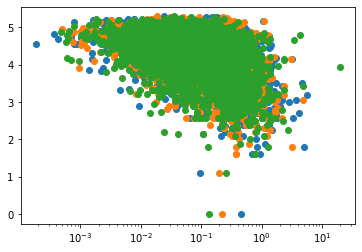

In [230]:
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 2], y)
plt.xscale('log')

In [231]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

def func(x):
    return np.log(x+eps)

pipe = Pipeline([('imp', SimpleImputer()),
                 ('log', FunctionTransformer(func)),
#                  ('poly', PolynomialFeatures(3, include_bias=False)),
#                  ('reg', LinearRegression())])
                 ('reg', SVR(kernel='rbf'))])
                 
                 
pipe.fit(X, y)
pipe.score(X, y)

0.3486227858644553

1.0066110884671906 0.11737611826966803


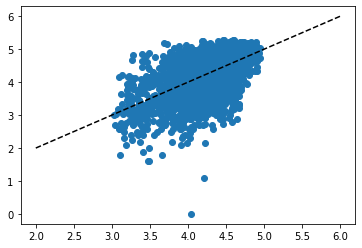

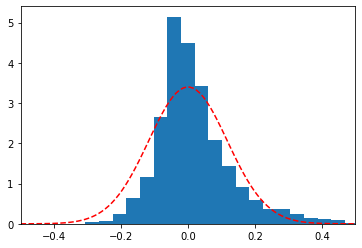

In [253]:
y_pred = pipe.predict(X)
plt.scatter(y_pred, y)
# plt.xlim([0, 100])
# plt.ylim([0, 100])
plt.plot([2, 6], [2, 6], 'k--')
plt.figure()
plt.hist(y_pred/y-1, bins=np.linspace(-1, 1), density=True);
plt.xlim([-0.5, 0.5])
from scipy.stats import norm
x = np.linspace(-0.5, 0.5, 100)
plt.plot(x, norm.pdf(x, 0, np.percentile(y_pred/y-1, 84)), 'r--')
print(np.mean(y_pred/y-1), np.percentile(y_pred/y-1, 84))

In [237]:
data_2023 = np.load('data_2023.npz')
X_2023 = data_2023['X'][:, :3]
riders_2023, indices = remove_(data_2023['riders'])
# riders_2023 = data_2023['riders']
X_2023 = X_2023[indices]
pred_2023 = pipe.predict(X_2023)

In [242]:
#Some good riders for the scorito poule
df = pd.DataFrame({'rider': riders_2023, 'pred': pred_2023}).sort_values('pred')
df.head(20)

,rider,pred
13,jonas-vingegaard-rasmussen,3.107175
98,wout-van-aert,3.239487
34,adam-yates,3.268737
119,mathieu-van-der-poel,3.354197
41,mattias-skjelmose-jensen,3.376465
31,pello-bilbao,3.377256
92,carlos-rodriguez-cano,3.409588
99,stefan-kung,3.441944
30,jasper-philipsen,3.517881
4,enric-mas,3.541255


In [239]:
def get_rider_pred(substr):
    df_ = df[df['rider'].str.contains(substr)]
    print(df_['rider'].iloc[0], df_['pred'].iloc[0])

get_rider_pred('meeus')
get_rider_pred('groenewegen')
get_rider_pred('girmay')
get_rider_pred('coquard')
get_rider_pred('cavendish')
get_rider_pred('philipsen')
get_rider_pred('bauhaus')
get_rider_pred('sagan')
get_rider_pred('mozz')
get_rider_pred('poppel')
get_rider_pred('aranburu')

jordi-meeus 4.413119543162442
dylan-groenewegen 4.288011630306735
biniam-girmay 3.9556466990258605
bryan-coquard 4.338984268627281
mark-cavendish 4.365444846750352
jasper-philipsen 3.517881020813983
phil-bauhaus 4.450808210170355
peter-sagan 4.419303145053452
luca-mozzato 4.38446401056438
danny-van-poppel 4.397188858163872
alex-aranburu 4.014440804374799


In [240]:
get_rider_pred('connor')
get_rider_pred('bardet')
get_rider_pred('gaudu')
get_rider_pred('meintjes')
get_rider_pred('guillaume-martin')
get_rider_pred('landa')
get_rider_pred('rodriguez')
get_rider_pred('enric-mas')
get_rider_pred('bilbao')

ben-o-connor 3.7866014950826234
romain-bardet 3.648908997759658
david-gaudu 3.608471655125216
louis-meintjes 4.19797254172333
guillaume-martin 3.8171179015333645
mikel-landa 3.8317886245377974
carlos-rodriguez-cano 3.4095877132520833
enric-mas 3.541254798321532
pello-bilbao 3.3772556648073615


In [241]:
get_rider_pred('van-der-poel')
get_rider_pred('powless')
get_rider_pred('pidcock')
get_rider_pred('alaphi')
get_rider_pred('cicco')

mathieu-van-der-poel 3.35419704561097
neilson-powless 3.72633597060312
thomas-pidcock 3.563916536460713
julian-alaphilippe 3.7259931691830093
giulio-ciccone 3.8699173678376226


In [ ]:
a yates, mohoric, kung, bilbao, s yates, rodriguez, laporte, mvdwp, wva, pidcock